In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import image as tf_image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Dropout, Conv2DTranspose
from tensorflow.keras.utils import Sequence

2024-06-24 03:02:19.508480: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-24 03:02:19.599091: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-24 03:02:20.876732: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


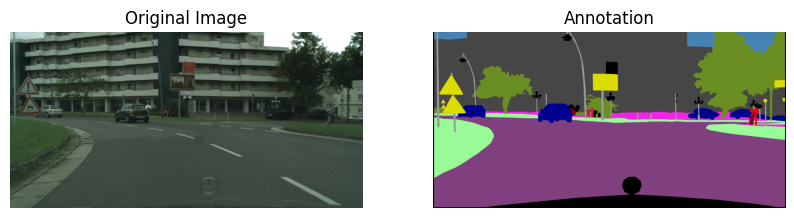

In [2]:
def load_and_display_image(image_path, annotation_path):
    # Load images
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    annotation = cv2.imread(annotation_path)
    annotation = cv2.cvtColor(annotation, cv2.COLOR_BGR2RGB)
    
    # Display images
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(image)
    axs[0].set_title('Original Image')
    axs[0].axis('off')
    
    axs[1].imshow(annotation)
    axs[1].set_title('Annotation')
    axs[1].axis('off')
    
    plt.show()

# Example paths
image_path = '/home/maith/Desktop/Cityscapes/leftImg8bit_trainvaltest/train/aachen/aachen_000000_000019_leftImg8bit.png'
annotation_path = '/home/maith/Desktop/Cityscapes/gtFine_trainvaltest/train/aachen/aachen_000000_000019_gtFine_color.png'
load_and_display_image(image_path, annotation_path)

In [3]:
class CityscapesDataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, image_paths, annotation_paths, batch_size=8, dim=(256, 512), n_channels=3,
                 n_classes=30, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.image_paths = image_paths
        self.annotation_paths = annotation_paths
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.max_label = n_classes - 1
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_image_paths_temp = [self.image_paths[k] for k in indexes]
        list_annotation_paths_temp = [self.annotation_paths[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_image_paths_temp, list_annotation_paths_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_image_paths_temp, list_annotation_paths_temp):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)

        for i, (img_path, ann_path) in enumerate(zip(list_image_paths_temp, list_annotation_paths_temp)):
            img = cv2.imread(img_path)
            if img is None:
                raise ValueError(f"Image not loaded properly from path: {img_path}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = tf_image.resize(img, self.dim)

            ann = cv2.imread(ann_path, 0)
            if ann is None:
                raise ValueError(f"Annotation not loaded properly from path: {ann_path}")
            ann = np.expand_dims(ann, axis=-1)  # Add a new axis for channel
            ann = tf_image.resize(ann, self.dim, method='nearest')
            ann = np.squeeze(ann).astype(int)  # Squeeze to remove single-dimensional entries from the shape

            ann = self.remap_labels(ann)  # Remap labels if necessary
            ann = tf.keras.utils.to_categorical(ann, num_classes=self.n_classes)

            X[i,] = img
            y[i] = ann

        return X, y

    def remap_labels(self, ann):
        # Any label higher than max_label will be set to max_label
        ann[ann > self.max_label] = self.max_label
        return ann

In [4]:
def unet(input_size=(256, 512, 3), n_filters=64, n_classes=31):
    inputs = Input(input_size)
    
    # Contracting Path
    conv1 = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(n_filters * 2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(n_filters * 2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(n_filters * 4, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(n_filters * 4, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # Bottleneck
    conv4 = Conv2D(n_filters * 8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(n_filters * 8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    
    # Expansive Path
    up7 = Conv2DTranspose(n_filters * 4, (3, 3), strides=(2, 2), padding='same')(drop4)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(n_filters * 4, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(n_filters * 4, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    
    up8 = Conv2DTranspose(n_filters * 2, (3, 3), strides=(2, 2), padding='same')(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(n_filters * 2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(n_filters * 2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    
    up9 = Conv2DTranspose(n_filters, (3, 3), strides=(2, 2), padding='same')(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    
    # Output layer
    conv10 = Conv2D(n_classes, (1, 1), activation='softmax')(conv9)
    
    model = Model(inputs=inputs, outputs=conv10)
    return model

In [5]:
def get_matched_files(image_dir, annotation_dir, img_suffix='_leftImg8bit.png', ann_suffix='_gtFine_color.png'):
    image_files = {}
    annotation_files = {}
    
    # Map images and annotations to their base names
    for dirpath, _, filenames in os.walk(image_dir):
        for filename in filenames:
            if filename.endswith(img_suffix):
                base_name = filename.replace(img_suffix, '')
                full_path = os.path.join(dirpath, filename)
                image_files[base_name] = full_path

    for dirpath, _, filenames in os.walk(annotation_dir):
        for filename in filenames:
            if filename.endswith(ann_suffix):
                base_name = filename.replace(ann_suffix, '')
                full_path = os.path.join(dirpath, filename)
                annotation_files[base_name] = full_path

    # Match images and annotations
    matched_images = []
    matched_annotations = []
    for base_name, img_path in image_files.items():
        ann_path = annotation_files.get(base_name)
        if ann_path:
            matched_images.append(img_path)
            matched_annotations.append(ann_path)
        else:
            print(f"Warning: No matching annotation file for {img_path}")

    return matched_images, matched_annotations

# Using the function to get matched files
image_dir = '/home/maith/Desktop/Cityscapes/leftImg8bit_trainvaltest/train'
annotation_dir = '/home/maith/Desktop/Cityscapes/gtFine_trainvaltest/train'
image_files, annotation_files = get_matched_files(image_dir, annotation_dir)

# Now you can print to verify the matching
print(image_files[:5])
print(annotation_files[:5])

['/home/maith/Desktop/Cityscapes/leftImg8bit_trainvaltest/train/bochum/bochum_000000_009554_leftImg8bit.png', '/home/maith/Desktop/Cityscapes/leftImg8bit_trainvaltest/train/bochum/bochum_000000_023174_leftImg8bit.png', '/home/maith/Desktop/Cityscapes/leftImg8bit_trainvaltest/train/bochum/bochum_000000_016758_leftImg8bit.png', '/home/maith/Desktop/Cityscapes/leftImg8bit_trainvaltest/train/bochum/bochum_000000_004229_leftImg8bit.png', '/home/maith/Desktop/Cityscapes/leftImg8bit_trainvaltest/train/bochum/bochum_000000_024717_leftImg8bit.png']
['/home/maith/Desktop/Cityscapes/gtFine_trainvaltest/train/bochum/bochum_000000_009554_gtFine_color.png', '/home/maith/Desktop/Cityscapes/gtFine_trainvaltest/train/bochum/bochum_000000_023174_gtFine_color.png', '/home/maith/Desktop/Cityscapes/gtFine_trainvaltest/train/bochum/bochum_000000_016758_gtFine_color.png', '/home/maith/Desktop/Cityscapes/gtFine_trainvaltest/train/bochum/bochum_000000_004229_gtFine_color.png', '/home/maith/Desktop/Cityscapes/g

In [6]:
def explore_annotation_labels(annotation_paths):
    import numpy as np
    unique_labels = set()
    for path in annotation_paths:
        ann = cv2.imread(path, 0)
        unique = np.unique(ann)
        unique_labels.update(unique)
    print("Unique labels in annotations:", unique_labels)

# Call this function with a few annotation paths
explore_annotation_labels(annotation_files[:10])

Unique labels in annotations: {0, 33, 194, 192, 164, 70, 76, 45, 108, 16, 177, 210, 84, 117, 119, 153, 90}


In [7]:
# Get matched files for training
image_dir = '/home/maith/Desktop/Cityscapes/leftImg8bit_trainvaltest/train'
annotation_dir = '/home/maith/Desktop/Cityscapes/gtFine_trainvaltest/train'
image_files, annotation_files = get_matched_files(image_dir, annotation_dir)

# Instantiate the data generator
train_generator = CityscapesDataGenerator(
    image_paths=image_files,
    annotation_paths=annotation_files,
    batch_size=2,
    dim=(256, 512),
    n_channels=3,
    n_classes=31,
    shuffle=True
)

# Instantiate and compile the U-Net model
model = unet(input_size=(256, 512, 3), n_filters=64, n_classes=31)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, epochs=10, verbose=1)

2024-06-24 03:02:26.834685: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-06-24 03:02:26.834798: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: debian
2024-06-24 03:02:26.834815: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: debian
2024-06-24 03:02:26.835122: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 555.42.2
2024-06-24 03:02:26.835170: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 555.42.2
2024-06-24 03:02:26.835181: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:248] kernel version seems to match DSO: 555.42.2


Epoch 1/10


KeyboardInterrupt: 

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("TensorRT version: ", tf.__version__)

Num GPUs Available:  0
TensorRT version:  2.16.1


In [9]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0
